#**BRAID Worshop**: pybounds custom simulator tutorial
This tutorial will run through an advanced usage of **pybound** using a custom simulator.

In [ ]:
!pip install do_mpc
!pip install pybounds
!pip install pyvista[all]

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/BenCellini/3D-shape-render/refs/heads/main/model/cylinder3d.py'
r = requests.get(url)
with open('cylinder3d.py', 'w') as f:
    f.write(r.text)
f.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from cylinder3d import Cylinder3D
from pybounds import Simulator, EmpiricalObservabilityMatrix, FisherObservability

# Creating a custom simulator

The primary purpose of ***pybounds*** is to evaluate the observability of state variables describing a system. This is done by numerically simulating the system with perturbations to the initial state variables. This means that the system does not have to be in closed-form, e.g. $\dot{\mathbf{x}}(t) = f(\mathbf{x}(t), \mathbf{u}(t))$ to analyze it. We provide a basic `Simulator` class that works well for numerically simulating simple closed-form ODE's. However, it is often appropriate to build your own custom simulator. The main reason to build a custom simulator is if your system is not a simple ODE that can be simulated in Python and requires outside software/packages to simulate. Systems involving things like computational fluid dynamics, finite element analysis, physics engines, neural networks, etc. are all fair game as long as the simulation can be called from Python. This guide will illustrate how to get started building a custom simulator.

The main goal here is to write a `Simulator` class that will replace the default one, and can be used interchangeably with the other classes in ***pybounds***. For instance, `SlidingEmpiricalObservabilityMatrix` requires a `simulator` object:
```
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

```

# Calling your simulation from Python
If you have a system you want to simulate, first create a function in Python that can call it while modifying its initial state (`x0`) and inputs (`u`). This is the most important step, as you must figure out how to interact with whatever software you are using to simulate the system from Python.

If you want to call external software, you could start by trying to use some combination of bash commands (for instance, using `os.system()`) to run your simulation and load in its outputs. This step is fairly flexible from a code perspective, so you can add whatever extra function inputs that you want, such as simulation parameters like time-step size, etc,.

## 3D shape simulation
In this example, I will call a simulation that renders a 3D cylinder with a given position and orientation and outputs the rendered pixels as measurments, mimicking a measurment from a camera or visual system. We will try to uderstand which states (roll, pitch, yaw, x, y, z) are the most/least observable.

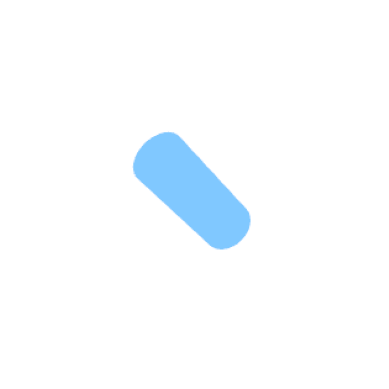

In [ ]:
# Render a cylinder at (x, y, z) = (0,0,0) and (roll, pitch, yaw) = (0, 45, 45)
# Can also change the camera zoom like a control input
# User can change the the cylinder paramaters and see how the image output changes
cylinder = Cylinder3D(size=1.0)
rgb_image, gray_image = cylinder.render(roll=0.0, pitch=45.0, yaw=45.0,
                                        x=0.0, y=0.0, z=0.,
                                        zoom=5.0)

fig, ax = plt.subplots()
ax.imshow(rgb_image)
ax.set_axis_off()

## Integrate simulation into `Simulator` class skeleton
This will show the basic skeleton of the `Simulator` class required for use with the main ***pybounds*** observability classes. This custom `simulator` you create will replace the default one provided by `simulator.py`. In this example, we will call the 3D render simulation from inside the class.

In [ ]:
class Simulator(object):
    def __init__(self, params=None):

        """ Initialize the simulator object.
        :param params: optional inputs to initialize your simulator.
        """

        # Here you can add things like the names of the states, inputs & measurements
        # These properties are not required but can be helpful for interpreting the observability results later on
        # Note that the length of state/input/measurement names must match the simulation properties, e.g. the number of states in your simulator must match len(self.state_names).
        self.state_names = ('phi', 'theta', 'psi', 'x', 'y', 'z') # [roll, pitch, yaw, x, y, z]
        self.input_names = ('zoom',)  # [zoom scale]
        # self.measurment_names = []  # measurement names can also be set, but for this example we will let them be set automatically

        # Set up initial shape
        self.shape3d = Cylinder3D(size=1.0, color_gradient_axis='y', cmap=params)

    def simulate(self, x0=None, u=None, aux=None, return_image=False):
        """ Simulate method.

        :param x0: required initial state vector
        :param u: initial input vector over time, if your simulation does not have inputs just leave u=None
        :param aux: initial auxiliary input, unused in this example but is useful for providing time-varying parameters for sliding window observability analysis
        :param return_image: optional extra input specific to the outside simulation being called

        :return y: measurements over time. Must have the different measurements as columns & time-steps as rows. Y = [y_0, y_1, ... , y_p]
        """

        # Here you can add your own simulation code
        # It could call some external simulation function that is dependent on x0.
        # Possible inputs u, and any other possible parameters you wish to include can also be added, but that is entirely up to the user.
        # In this example, we call a 3D rendering simulation:

        # Set the orientation, position, and camera zoom
        roll = x0[0]
        pitch = x0[1]
        yaw = x0[2]
        x = x0[3]
        y = x0[4]
        z = x0[5]
        zoom = u[0, 0]

        # Render the image
        rgb_image, gray_image = self.shape3d.render(roll=roll, pitch=pitch, yaw=yaw, x=x, y=y, z=z, zoom=zoom)

        # Flatten the gray-scale image for output
        image_condensed = np.atleast_2d(gray_image.flatten())

        # Return the RGB image if specified, otherwise output the flattened gray image
        if return_image:
          y = rgb_image
        else:
          y = image_condensed

        return y

Now check that you can call your `simulate` method and make sure it works

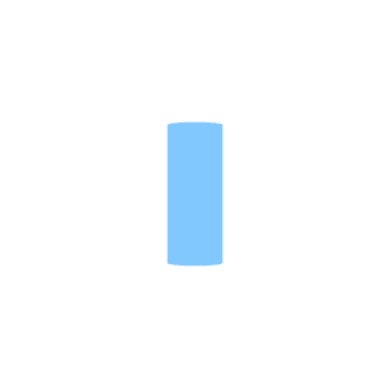

In [ ]:
# Construct your simulator object
simulator = Simulator()
# simulator = Simulator(params='jet')  # uncomment this to get a cylinder with a color gradient

# Set your initial state and input
x0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # [roll, pitch, yaw, x, y, z]
u = np.atleast_2d([5.0]) # [zoom]

# Run simulation
y = simulator.simulate(x0, u, return_image=True)

# Plot
fig, ax = plt.subplots()
ax.imshow(y)
ax.set_axis_off()

# Construct observability matrix & compute Fisher information matrix & inverse
These steps work exactly the same as with the default `Simulator`, assuming you have correctly set up you custom `Simulator`.

In this example, the rows of the observability matrix correspond to individual pixel measurments. We will only compute one observability matrix (no sliding windows) because we only care about the first time step.

In [ ]:
EOM = EmpiricalObservabilityMatrix(simulator, x0, u, aux=None, eps=0.5)
O = EOM.O_df
O

,,phi,theta,psi,x,y,z
sensor,time_step,,,,,,
y_0,0,0.0,0.0,0.0,0.0,0.0,0.0
y_1,0,0.0,0.0,0.0,0.0,0.0,0.0
y_2,0,0.0,0.0,0.0,0.0,0.0,0.0
y_3,0,0.0,0.0,0.0,0.0,0.0,0.0
y_4,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
y_89995,0,0.0,0.0,0.0,0.0,0.0,0.0
y_89996,0,0.0,0.0,0.0,0.0,0.0,0.0
y_89997,0,0.0,0.0,0.0,0.0,0.0,0.0


Compute the Fisher Information with each pixel having a variance of 100 bit.

Set `force_scalar_R=True` because the resulitng R matrix is too big to fit into memory.

Note that resulting minimum error variance for each state. The roll state ($\phi$) is very large (unobservable), while the other states are all very small (observable).

Try going back and recreating the object with a different texture (color gradient) and see if this changes this result.

In [ ]:
FO = FisherObservability(O, R=100.0, force_R_scalar=True, lam=1e-8)
EV = FO.error_variance
EV

,phi,theta,psi,x,y,z
0,100000000.0,0.00005,0.000017,0.000001,4.642319e-07,5.249774e-07


# Exercises
There is only one open-ended exersice for this tutorial, which is to start thinking about how to integrate your own models/systems into the **pybounds** framework. Think of a question in your own research that you might be able to answer with these tools and how to frame the question correctly in the context of observability.